# Learning to Rank (LeToR)

In [15]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.35
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False
# The zero values 

In [17]:
def GetTargetVector(filePath): 
    # To get target variable in vector format
    t = []
    with open(filePath, newline='') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    # returns target vector
    return t 

def GenerateRawData(filePath, IsSynthetic):   
    # To get input dataset in matrix format
    dataMatrix = [] 
    with open(filePath, newline='') as fi:
    #changed the newline='' to avoid the warning associated with opening a file in 'rU' mode
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1) 
        #Columns 5-9 are removed DataMatrix as they all contain only '0' as their values
    dataMatrix = np.transpose(dataMatrix)   
    #Returns transpose dataMatrix of shape (41,69623) 
    return dataMatrix  

In [18]:
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    # Generating the training output of shape(55699,) 
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t = rawTraining[:TrainingLen]
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80): 
    # Generating training dataMatrix of shape(41,55699)
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    # Generating Validation dataMatrix of shape(41,6962)
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    # Generating Validation target of shape(6962,)
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t


In [19]:
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    #Generating BigSigma of shape(41,41)
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j] 
        # Each value of varVect is getting assigned in BigSigma diagonally
    if IsSynthetic == True: 
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    # Returns Bigsigma 
    return BigSigma 


In [20]:
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    # It will return a single real valued vector, which is a scalar
    return L 

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data) # (69623,41)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01)) # 55699        
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) #(55699,10)
    BigSigInv = np.linalg.inv(BigSigma) #(41,41)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
# returns PHI of shape(55699,10)
return PHI 

In [21]:
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0])) # (10,10)
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    #return the weights of shape(10,)
    return W 

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

In [22]:
def GetErms(VAL_TEST_OUT,ValDataAct): # Defining root mean square
    sum = 0.0
    accuracy = 0.0
    counter = 0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

# Fetch and Prepare Dataset

In [23]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

# Prepare Training Data

In [24]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


# Prepare Validation Data

In [25]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


# Prepare Test Data

In [26]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)

(6961,)
(41, 6961)


Text(0.5, 1.0, 'Number of Clusters Vs Sum of squares within Clusters')

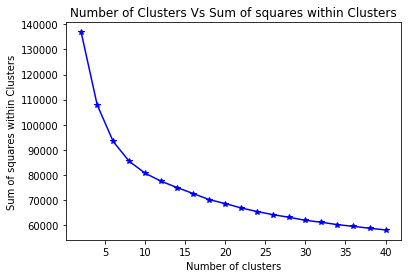

In [44]:
kmeans_list = [2*k for k in range(1,21)]
SumofSquares = [] # Within cluster sum of square
for i in kmeans_list:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(np.transpose(TrainingData))
    SumofSquares.append(kmeans.inertia_)
#plotting the graph
plt.plot(kmeans_list,SumofSquares,'b*-')
plt.ylabel("Sum of squares within Clusters")
plt.xlabel("Number of clusters")
plt.title("Number of Clusters Vs Sum of squares within Clusters")

# Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [28]:
ErmsArr = []
AccuracyArr = []
M = 7 # Number of clusters
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))

Mu = kmeans.cluster_centers_ #returns center of clusters

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [29]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(7, 41)
(41, 41)
(55699, 7)
(7,)
(6962, 7)
(6961, 7)


Text(0.5, 1.0, 'Lamda Vs Training Accuracy')

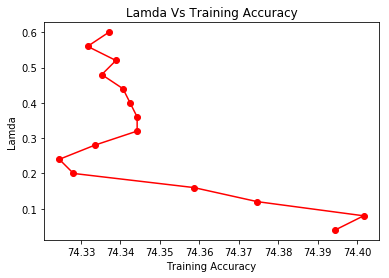

In [46]:
# To select a value of lamda with Training data
Lamda=[l*0.04 for l in range(1,16)]
TrainingAcc = []
for lamda in Lamda:
  w = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,lamda) 
  TR_TEST_OUT  = GetValTest(TRAINING_PHI,w)
  Training_Accuracy= str(GetErms(TR_TEST_OUT,TrainingTarget))
  TrainingAcc.append(float(Training_Accuracy.split(',')[0]))
#Plotting the Graph
plt.plot(TrainingAcc,Lamda,'ro-')
plt.xlabel("Training Accuracy")
plt.ylabel("Lamda")
plt.title("Lamda Vs Training Accuracy")

In [ ]:
# To select a value of lamda with validation data

Lamda=[l*0.04 for l in range(1,16)]
ValidationAcc = []
for lamda in Lamda:
  w_= GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,lamda) 
  VAL_TEST_OUT = GetValTest(VAL_PHI,w_)
  Validation_Accuracy= str(GetErms(VAL_TEST_OUT,TrainingTarget))
  ValidationAcc.append(float(Validation_Accuracy.split(',')[0]))
#Plotting the Graph
plt.plot(ValidationAcc,Lambda,'r*-')
plt.xlabel("Validation Accuracy")
plt.ylabel("Lamda")
plt.title("Lamda Vs Training Accuracy")

# Finding Erms on training, validation and test set

In [32]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [ ]:
print ('UBITname      = vganesh2')
print ('Person Number = 50288433')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 7 \nLambda = 0.3\n")

print("Accuracy")
print("Training accuracy = " +TrainingAccuracy.split(',')[0])
print("Validation accuracy = "+ValidationAccuracy.split(',')[0])
print("Test accuracy =  "+TestAccuracy.split(',')[0]+"\n")

print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

# Gradient Descent solution for Linear Regression

In [34]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [35]:
W_Now        = np.dot(220, W) # We intialize it with random value(220)
La           = 2 # Lamda
learningRate = 0.03
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,400): 
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

Text(0.5, 1.0, 'Learning Rate Vs E_rms')

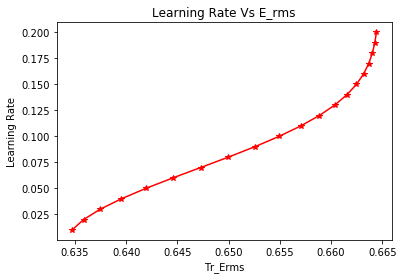

In [49]:
# To find the learning rate 
Learningrate = [0.01*i for i in range(1,21)]
Tr_Erms=[]
for lr in Learningrate:
    
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(lr,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    Tr_Erms.append(float(Erms_TR.split(',')[1]))

#plotting the graph   
plt.plot(Tr_Erms,Learningrate,'r*-')
plt.xlabel("Tr_Erms")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Vs E_rms")

In [37]:
print ('----------Gradient Descent Solution--------------------')

print("Accuracy")
print("Training accuracy is " +TrainingAccuracy.split(',')[0])
print("Validation accuracy is "+ValidationAccuracy.split(',')[0])
print("Test accuracy is "+TestAccuracy.split(',')[0]+"\n")

print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
Accuracy
Training accuracy is 74.34603852851936
Validation accuracy is 74.8635449583453
Test accuracy is 70.1910645022267

E_rms Training   = 0.55143
E_rms Validation = 0.54065
E_rms Testing    = 0.62464
